In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import feature_selection as fs
import numpy.random as nr

In [ ]:
data = pd.read_csv(r'/content/carbonemissions_improved.csv')


In [ ]:
random_state_num = 0

In [ ]:
data = data[data['country']!='ARE']


print("Shape of the dataset after removing the ARE outliers:")
data.shape

Shape of the dataset after removing the ARE outliers:


(1686, 16)

In [ ]:
feature_cols = ['cereal_yield','fdi_perc_gdp','gni_per_cap', 'en_per_cap',
                'pop_urb_aggl_perc', 'prot_area_perc']
label_col = ['co2_per_cap']

features = np.array(data[feature_cols])
labels =  np.array(data[label_col])

In [ ]:
features

array([[ 417.4       ,    5.44951458,  820.        ,  565.4510272 ,
          15.29072799,   12.39982205],
       [ 397.        ,    4.98245985,  470.        ,  550.54826405,
          15.66062978,   12.39982269],
       [ 267.8       ,    5.71552893,  310.        ,  551.68887814,
          16.02573922,   12.39982333],
       ...,
       [1816.1       ,    5.7538601 ,  620.        ,  628.74067934,
          11.0807946 ,   35.98301766],
       [1907.9       ,   11.47085026,  750.        ,  612.26486025,
          11.10395156,   35.98301766],
       [2144.        ,    6.41099075,  970.        ,  614.85174172,
          11.10960505,   35.98301766]])

In [ ]:
nr.seed(1)
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.2,
                                                                            random_state=random_state_num)

In [ ]:
nr.seed(1)
feature_folds = ms.KFold(n_splits=4, shuffle = True, random_state=random_state_num)

# Define the model
rf_selector = RandomForestRegressor(random_state=random_state_num)

nr.seed(1)
selector = fs.RFECV(estimator = rf_selector, cv = feature_folds, scoring = 'r2', n_jobs=-1)

selector = selector.fit(features_train, np.ravel(labels_train))

selector.support_
print("Feature ranking after RFECV:")
print(selector.ranking_)


ranks_transform = list(np.transpose(selector.ranking_))
chosen_features = [i for i,j in zip(feature_cols,ranks_transform) if j==1]
print("Chosen important features:")
print(chosen_features)

Feature ranking after RFECV:
[1 2 1 1 1 1]
Chosen important features:
['cereal_yield', 'gni_per_cap', 'en_per_cap', 'pop_urb_aggl_perc', 'prot_area_perc']


In [ ]:
features_train_reduced = selector.transform(features_train)
features_test_reduced = selector.transform(features_test)

print("Training subset shape before the recursive feature elimination: ",features_train.shape)
print("Training subset array shape after the recursive feature elimination: ", features_train_reduced.shape)
print("Test subset array shape after the recursive feature elimination: ",features_test_reduced.shape)

Training subset shape before the recursive feature elimination:  (1348, 6)
Training subset array shape after the recursive feature elimination:  (1348, 5)
Test subset array shape after the recursive feature elimination:  (338, 5)


In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

param_grid = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2', None] ,
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
nr.seed(1)
inside_folds = ms.KFold(n_splits=5, shuffle = True, random_state=random_state_num)

rf_tuner = RandomForestRegressor(random_state=random_state_num)

nr.seed(1)
rf_model = ms.RandomizedSearchCV(estimator=rf_tuner, param_distributions = param_grid,
                                 random_state=random_state_num, refit=True,
                                 cv=inside_folds, scoring = 'r2', return_train_score=True, n_jobs=-1)

In [ ]:
rf_model.fit(features_train_reduced, np.ravel(labels_train))


print("Best Parameters:", rf_model.best_params_)

Best Parameters: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [ ]:
rf_best_model = rf_model.best_estimator_

In [ ]:
nr.seed(1)
outside_folds = ms.KFold(n_splits=10, shuffle = True, random_state=random_state_num)

nr.seed(1)
cv_eval = cross_val_score(rf_best_model, features_train_reduced, labels_train, cv = outside_folds, n_jobs=-1)

print('Mean R2 score of all CV folds = %4.3f' % np.mean(cv_eval))
print('Standard deviation of the R2 score over all folds = %4.3f' % np.std(cv_eval))
print('R2 score for each fold:')


for i, j in enumerate(cv_eval):
    print('Fold %2d    %4.3f' % (i+1, j))

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean R2 score of all CV folds = 0.988
Standard deviation of the R2 score over all folds = 0.005
R2 score for each fold:
Fold  1    0.994
Fold  2    0.992
Fold  3    0.992
Fold  4    0.992
Fold  5    0.978
Fold  6    0.989
Fold  7    0.984
Fold  8    0.988
Fold  9    0.987
Fold 10    0.989


In [ ]:
predictions = rf_best_model.predict(features_test_reduced)

# calculate the metrics basing on the predicted and true values for the test subset
r2 = r2_score(y_true=labels_test, y_pred=predictions)
mse = mean_squared_error(y_true=labels_test, y_pred=predictions)
rmse = np.sqrt(mse)

print(f"R2 = {r2}, Mean Squared Error (MSE) = {mse}, Root Mean Squared Error (RMSE) = {rmse}")

R2 = 0.9879540423112994, Mean Squared Error (MSE) = 0.23167789731588956, Root Mean Squared Error (RMSE) = 0.48132930236573956


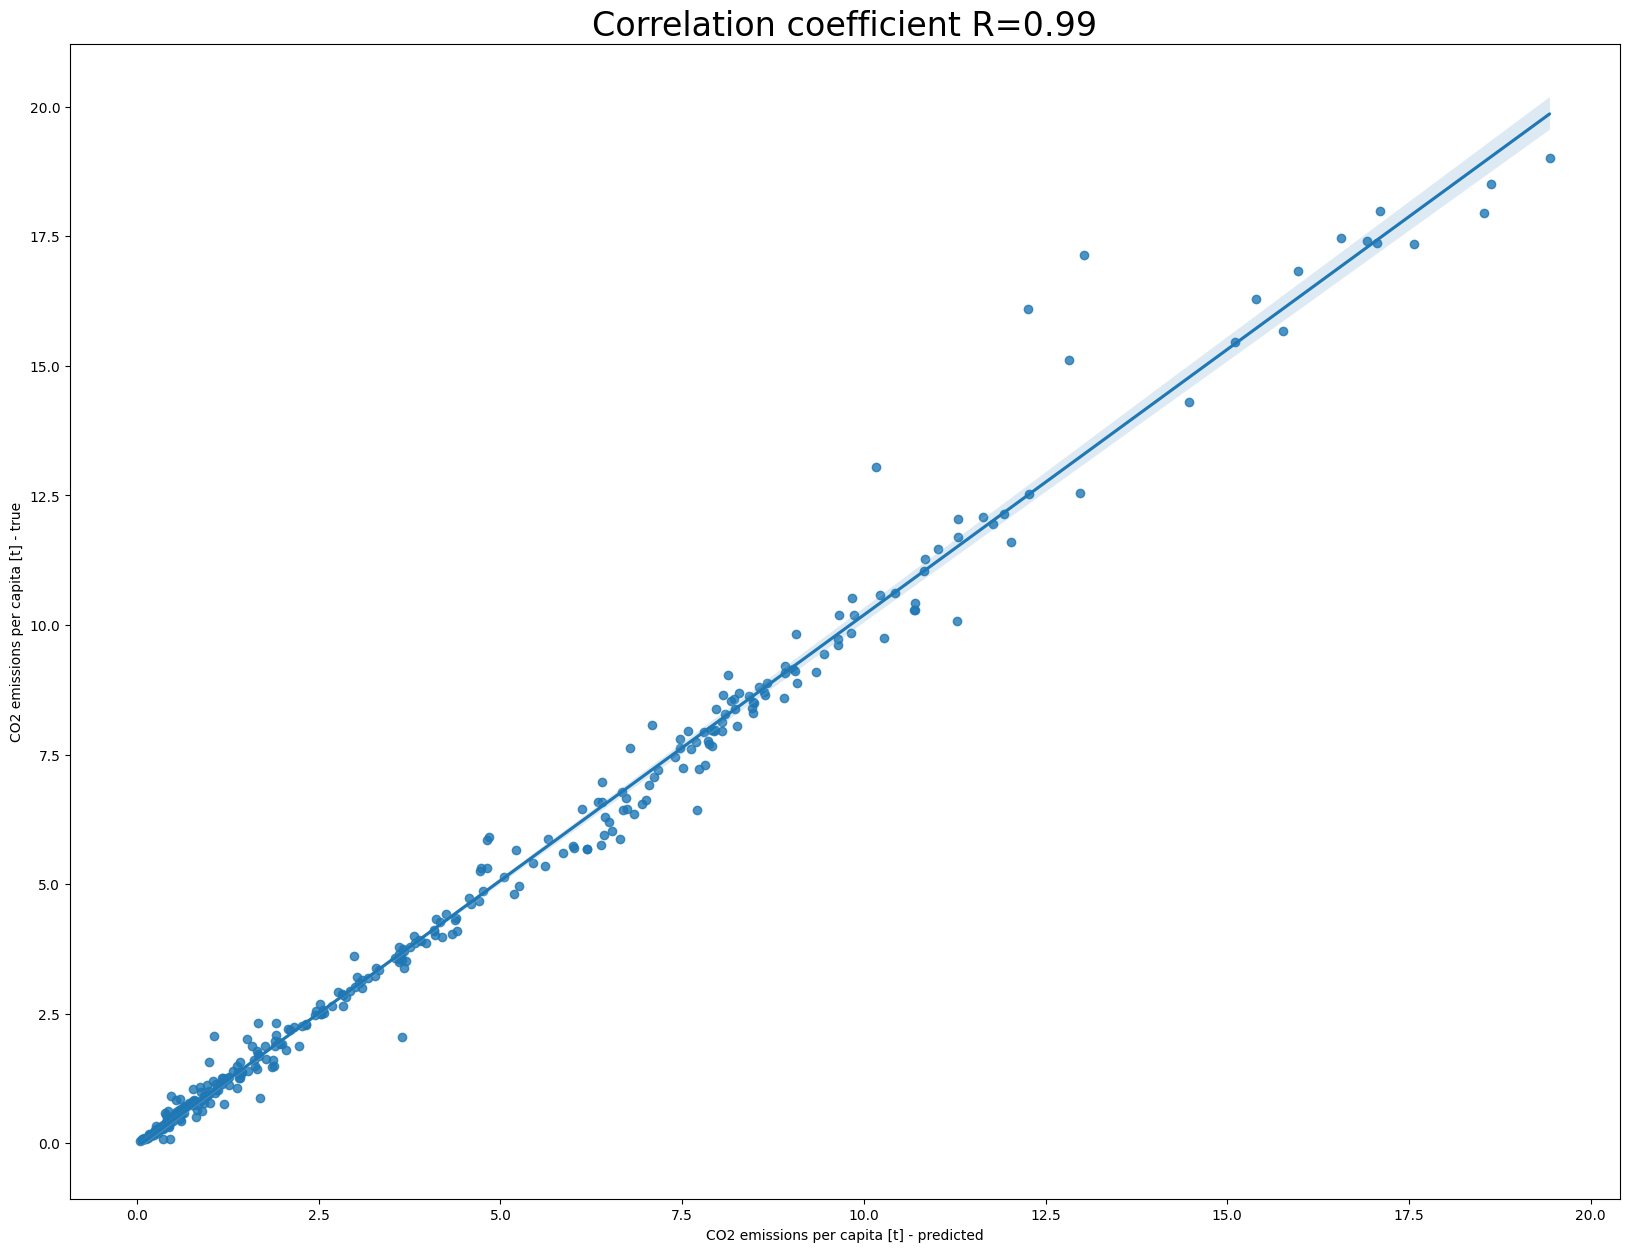

In [ ]:
import seaborn as sns
# plot predicted vs true values of the test subset

f,ax=plt.subplots(figsize=(20,15))
sns.set_theme(font_scale=2)

sns.regplot(x=predictions, y=np.transpose(labels_test)[0,:], fit_reg=True)
plt.xlabel("CO2 emissions per capita [t] - predicted")
plt.ylabel("CO2 emissions per capita [t] - true")
plt.title("Correlation coefficient R="+str(round(np.corrcoef(predictions,np.transpose(labels_test)[0,:])[0,1],2)))
plt.show()

In [ ]:
import joblib
joblib.dump(rf_best_model, 'forecasting_co2_emmision.pkl')
print("Model saved to 'forecasting_co2_emmision.pkl")

Model saved to 'forecasting_co2_emmision.pkl


In [ ]:
selected_features = ['cereal_yield', 'gni_per_cap', 'en_per_cap',
                     'pop_urb_aggl_perc', 'prot_area_perc',
                    ]

In [ ]:
selected_countries = ['IND', 'KOR', 'JPN', 'CHN', 'THA']

# Filter the dataset to include only the selected countries
df_filtered = data[data['country'].isin(selected_countries)]

# Dictionary to store the growth rates for each country
growth_rates = {}

# Loop over each selected country
for country in selected_countries:
    # Get data for the current country and sort it by year
    country_data = data[(data['country'] == country)].sort_values('year')

    # Identify the start and end year for the country
    start_year = country_data['year'].min()
    end_year = country_data['year'].max()
    years = end_year - start_year  # Total number of years between start and end

    # Dictionary to store growth rates of all features for the current country
    country_growth = {}

    # Skip this country if the time span is not valid (e.g., only one year of data)
    if years <= 0:
        print(f"Skipping {country} due to insufficient year range.")
        continue
   # Loop through each selected feature
    for feature in selected_features:
        # Get the feature value in the start year
        start_value = country_data[country_data['year'] == start_year][feature].values
        # Get the feature value in the end year
        end_value = country_data[country_data['year'] == end_year][feature].values

        # Skip if either value is missing
        if len(start_value) == 0 or len(end_value) == 0:
            continue

        # Extract scalar values from arrays
        start_value = start_value[0]
        end_value = end_value[0]

        # Skip if values are non-positive or not finite (e.g., NaN, inf)
        if start_value <= 0 or end_value <= 0 or not np.isfinite(start_value) or not np.isfinite(end_value):
            continue

        # Compute the Compound Annual Growth Rate (CAGR)
        cagr = (end_value / start_value) ** (1 / years) - 1
        # Store the result in the country-specific dictionary
        country_growth[feature] = cagr

    # Save the growth rates of all features for the current country
    growth_rates[country] = country_growth

In [ ]:
# Display the calculated growth rates in a readable format
print("\nGrowth Rates (CAGR) from {} to {}:\n".format(start_year, end_year))

# Loop through each country and its corresponding growth rate dictionary
for country, features in growth_rates.items():
    print(f"{country}")  # Print the country name with an icon

    # Loop through each feature and its CAGR value
    for feature, rate in features.items():
        # Determine whether to display a plus or minus sign
        sign = '+' if rate >= 0 else '−'

        # Print the feature name and its growth rate percentage (formatted to two decimal places)
        print(f"  • {feature}: {sign}{abs(rate * 100):.2f}%")

    # Add a line break between countries for readability
    print()


Growth Rates (CAGR) from 1991 to 2008:

IND
  • cereal_yield: +1.94%
  • gni_per_cap: +6.85%
  • en_per_cap: +2.12%
  • pop_urb_aggl_perc: +1.26%
  • prot_area_perc: +0.35%

KOR
  • cereal_yield: +1.24%
  • gni_per_cap: +6.86%
  • en_per_cap: +4.23%
  • pop_urb_aggl_perc: −0.36%
  • prot_area_perc: +0.56%

JPN
  • cereal_yield: +0.86%
  • gni_per_cap: +1.84%
  • en_per_cap: +0.47%
  • pop_urb_aggl_perc: +0.32%
  • prot_area_perc: +1.21%

CHN
  • cereal_yield: +1.60%
  • gni_per_cap: +13.58%
  • en_per_cap: +4.60%
  • pop_urb_aggl_perc: +3.71%
  • prot_area_perc: +1.19%

THA
  • cereal_yield: +1.63%
  • gni_per_cap: +4.76%
  • en_per_cap: +4.08%
  • pop_urb_aggl_perc: −0.16%
  • prot_area_perc: +1.50%



In [ ]:
last_year = data['year'].max()
future_years = list(range(last_year + 1, last_year + 21))

In [ ]:
forecast_results = []

# Load the saved model
loaded_model = joblib.load('forecasting_co2_emmision.pkl')


# Loop through each selected country for prediction
for country in selected_countries:
    country_data = data[(data['country'] == country)].sort_values('year')

    # Skip countries with missing feature values
    if country_data[selected_features].dropna().empty:
        print(f"Skipping {country} due to missing values.")
        continue

    # Take the latest complete record (most recent year) for the country
    latest_row = country_data[selected_features].dropna().iloc[-1].copy()

    # Forecast for each year into the future
    for year in future_years:
        # Apply the previously calculated CAGR to each feature
        for feature in selected_features:
            growth_rate = growth_rates.get(country, {}).get(feature, 0.0)
            latest_row[feature] *= (1 + growth_rate)

        # Use trained model to predict CO₂ emissions per capita
        input_features = latest_row.values.reshape(1, -1)
        predicted_co2 = loaded_model.predict(input_features)[0]

        # Store the forecast result
        forecast_results.append({
            'country': country,
            'year': year,
            'co2_percap': predicted_co2
        })

📈 Forecasted CO₂ Emissions per Capita (Next 20 Years)


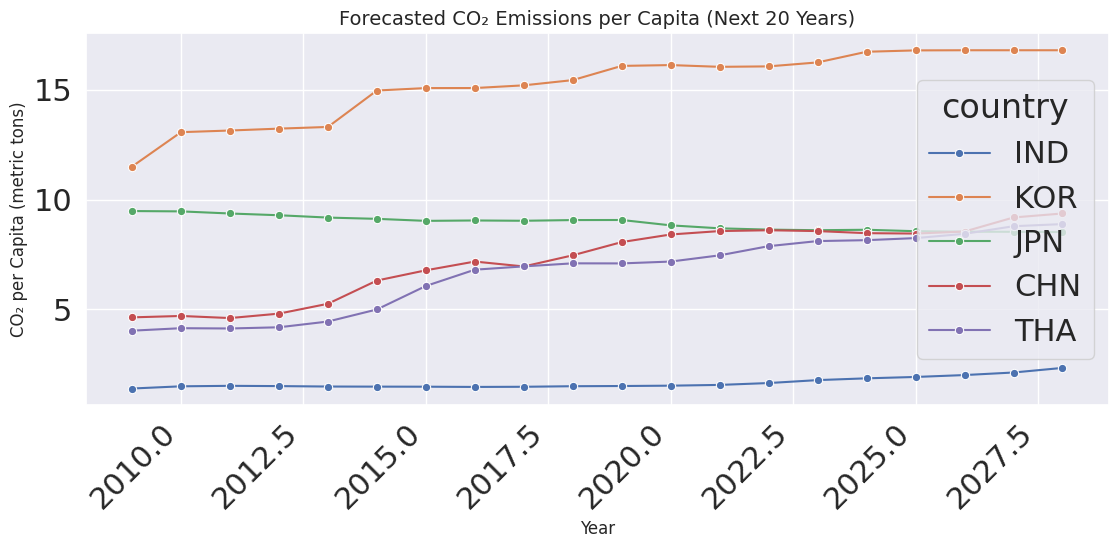


📊 Forecasted CO₂ per Capita for Last 5 Years in Forecast Period (India):

   country  year  co2_percap
15     IND  2024    1.860347
16     IND  2025    1.922577
17     IND  2026    2.009302
18     IND  2027    2.125520
19     IND  2028    2.335127


In [ ]:
df_forecast = pd.DataFrame(forecast_results)

# Plot forecasted CO₂ per capita for all countries over the next 20 years
print('📈 Forecasted CO₂ Emissions per Capita (Next 20 Years)')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='year', y='co2_percap', hue='country', marker='o')
plt.title('Forecasted CO₂ Emissions per Capita (Next 20 Years)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO₂ per Capita (metric tons)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the forecast values for the last 5 years for India
print("\n📊 Forecasted CO₂ per Capita for Last 5 Years in Forecast Period (India):\n")
print(df_forecast[df_forecast['country'] == 'IND'].sort_values(by='year').tail(5))